In [20]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import yfinance as yf

**Fetching Dataset**

In [2]:
start_data = '2020-01-01'
end_date = '2023-12-31'

adani_port = yf.download('ADANIPORTS.NS', start=start_data, end=end_date)

[*********************100%%**********************]  1 of 1 completed


**Looking at the data**


In [3]:
adani_port.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,368.000000,379.250000,366.000000,377.649994,365.911530,11377167
2020-01-02,377.950012,384.700012,376.500000,383.149994,371.240601,5919760
2020-01-03,382.700012,384.350006,379.200012,382.500000,370.610779,3684824
2020-01-06,388.000000,388.000000,374.750000,380.200012,368.382294,12482680
2020-01-07,384.049988,389.750000,382.399994,384.799988,372.839294,8091465


In [4]:
adani_port.info()
adani_port.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2020-01-01 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       992 non-null    float64
 1   High       992 non-null    float64
 2   Low        992 non-null    float64
 3   Close      992 non-null    float64
 4   Adj Close  992 non-null    float64
 5   Volume     992 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.2 KB


,Open,High,Low,Close,Adj Close,Volume
count,992.000000,992.000000,992.000000,992.000000,992.000000,9.920000e+02
mean,651.043802,661.048843,639.620109,649.854385,642.254125,8.122745e+06
std,196.695014,198.916486,194.145933,195.925379,196.477625,9.989091e+06
min,216.000000,235.800003,203.000000,207.800003,203.566132,0.000000e+00
25%,480.000000,489.287506,465.887497,482.187492,472.363045,3.298195e+06
50%,724.174988,733.450012,711.500000,722.150024,713.371185,5.299489e+06
75%,782.449982,794.962509,771.675018,782.850021,778.177963,8.934296e+06
max,1095.000000,1102.400024,1072.750000,1094.300049,1094.300049,1.155175e+08


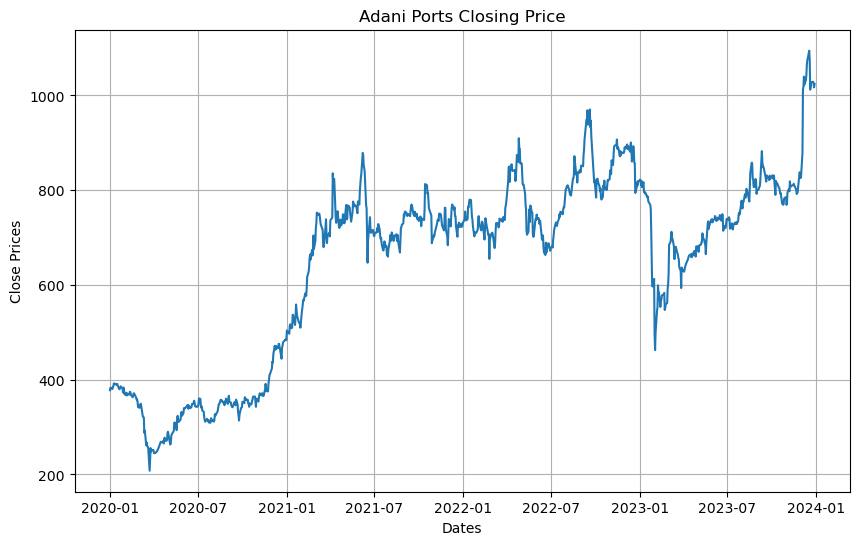

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(adani_port['Close'])
plt.title('Adani Ports Closing Price')
plt.show()

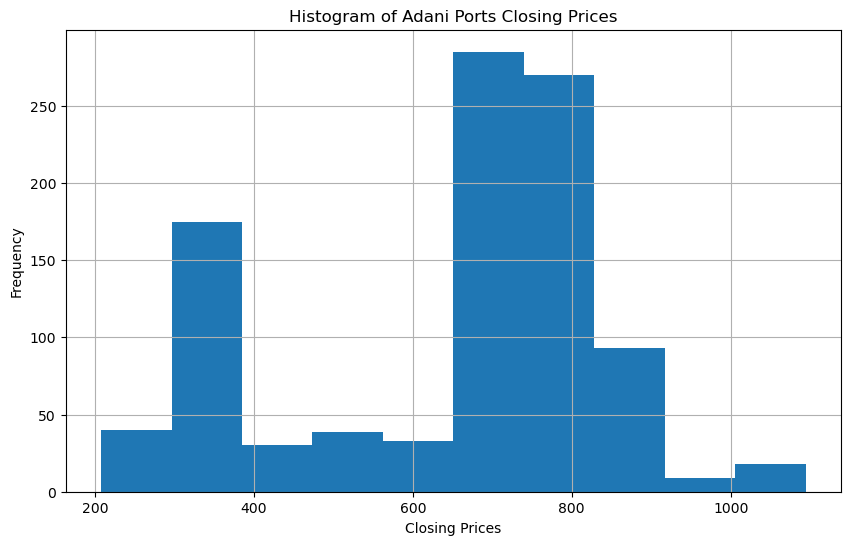

In [6]:
plt.figure(figsize=(10,6))
plt.hist(adani_port['Close'])
plt.grid(True)
plt.xlabel('Closing Prices')
plt.ylabel('Frequency')
plt.title('Histogram of Adani Ports Closing Prices')
plt.show()

**Checking the stationarity of the data**

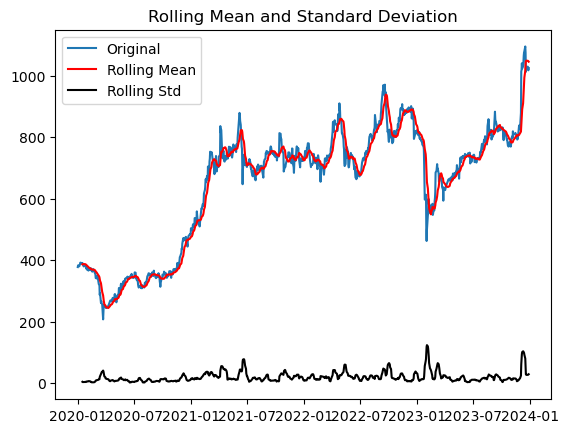

Result of Dickey-Fuller Test:
Test Statistics              -1.130445
p-value                       0.702779
No. of Lags Used              1.000000
No. of Observations Used    990.000000
Critical Value (1%)          -3.436973
Critical Value (5%)          -2.864464
Critical Value (10%)         -2.568327
dtype: float64


In [7]:
def test_stationarity(timeseries, window=12):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    # Plot rolling statistics
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean', color='red')
    plt.plot(rolstd, label='Rolling Std', color='black')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Result of Dickey-Fuller Test:')
    adft = adfuller(timeseries, autolag='AIC')
    
    # Create a Series to displa the Dickey-Fuller test results
    output = pd.Series(adft[0:4], index=['Test Statistics','p-value', 'No. of Lags Used', 'No. of Observations Used'])
    for key, value in adft[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
test_stationarity(adani_port['Close'])

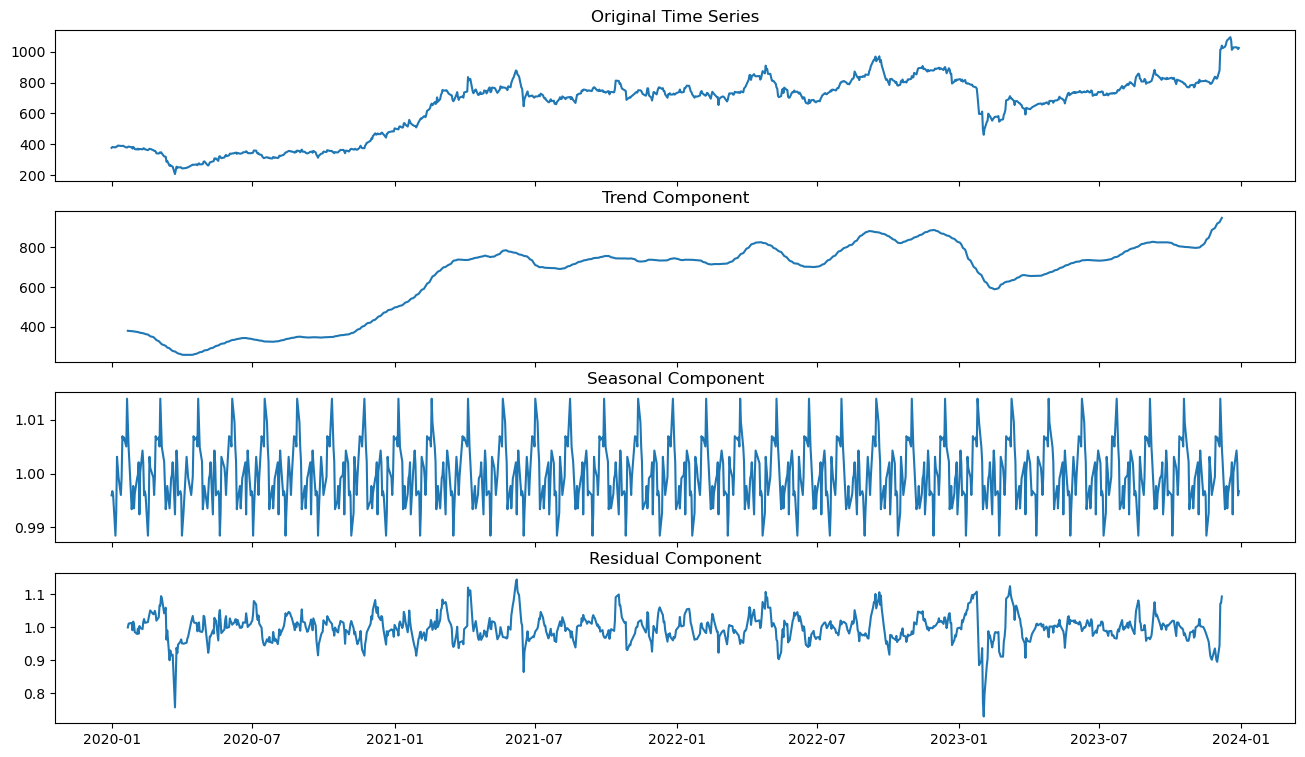

In [8]:
adani_port_close = adani_port['Close']
result = seasonal_decompose(adani_port_close, model='multiplicative', period=30)

# Plotting the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16,9), sharex=True)

ax1.set_title('Original Time Series')
ax1.plot(adani_port_close)

ax2.set_title('Trend Component')
ax2.plot(result.trend)

ax3.set_title('Seasonal Component')
ax3.plot(result.seasonal)

ax4.set_title('Residual Component')
ax4.plot(result.resid)

plt.show()

In [9]:
adani_port_log = np.log(adani_port['Close'])
adani_port_ma = adani_port_log.rolling(12).mean()
adani_port_std = adani_port_log.rolling(12).std()

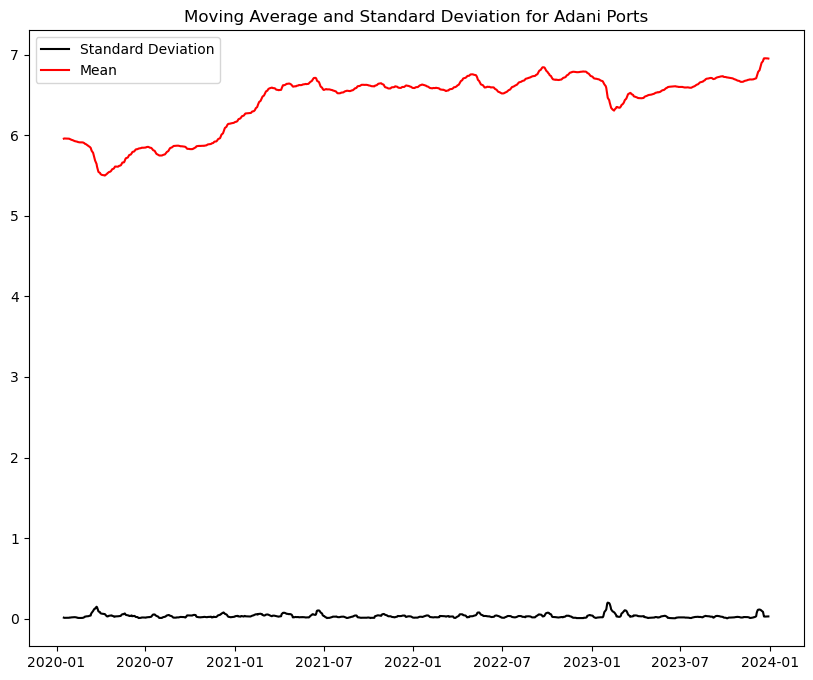

In [10]:
plt.figure(figsize=(10,8))
plt.plot(adani_port_std, color='black', label='Standard Deviation')
plt.plot(adani_port_ma, color='red',  label='Mean')
plt.legend()
plt.title('Moving Average and Standard Deviation for Adani Ports')
plt.show()

In [11]:
adani_port.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2020-01-01 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       992 non-null    float64
 1   High       992 non-null    float64
 2   Low        992 non-null    float64
 3   Close      992 non-null    float64
 4   Adj Close  992 non-null    float64
 5   Volume     992 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.2 KB


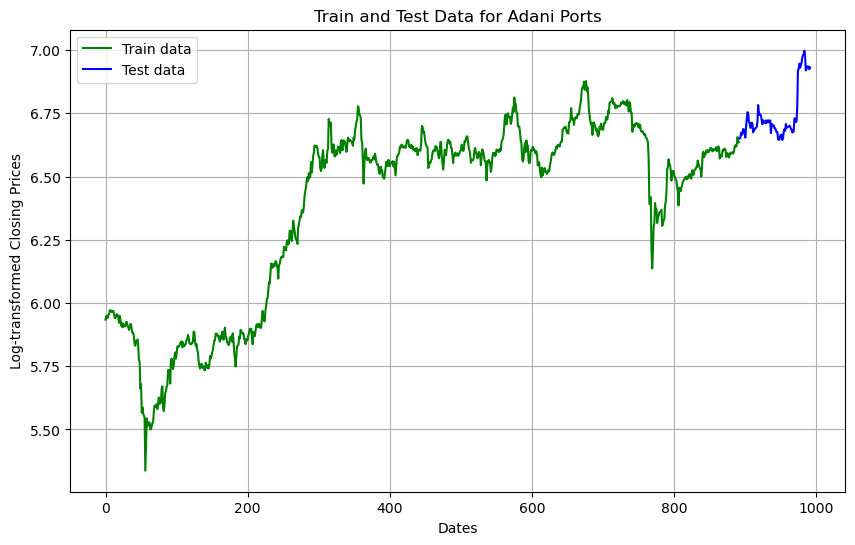

In [13]:
from sklearn.model_selection import train_test_split

X = adani_port_log.values.reshape(-1, 1)  # Reshape to make it compatible with scikit-learn
y = adani_port_log.values

# Split the data into training and test sets (90% training, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Plot the train and test data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log-transformed Closing Prices')
plt.plot(X_train, 'green', label='Train data')
plt.plot(len(X_train) + np.arange(len(X_test)), X_test, 'blue', label='Test data')
plt.legend()
plt.title('Train and Test Data for Adani Ports')
plt.show()


In [16]:
model_autoARIMA = auto_arima(X_train,
                            start_p=0, start_q=0,
                            test='adf',
                            max_p=3, max_q=3,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0, D=0,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True) 
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3913.887, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3912.316, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3912.381, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3915.122, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3915.329, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3914.743, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3914.714, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3914.220, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3914.018, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3911.827, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3916.600, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3913.649, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3913.584, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3915.764, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0

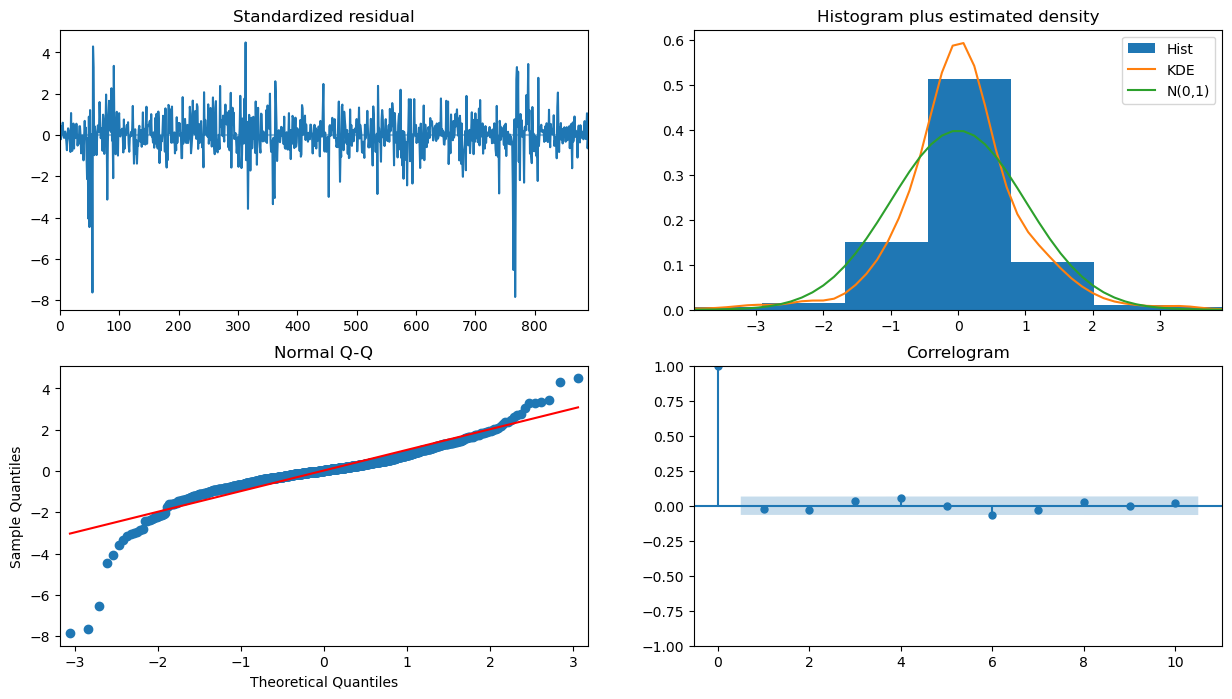

In [17]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
model = ARIMA(X_train, order=(3, 1, 2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  892
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1964.620
Date:                Fri, 05 Jan 2024   AIC                          -3917.240
Time:                        16:14:09   BIC                          -3888.486
Sample:                             0   HQIC                         -3906.251
                                - 892                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6416      0.163      3.926      0.000       0.321       0.962
ar.L2         -0.7058      0.143     -4.948      0.000      -0.985      -0.426
ar.L3          0.1067      0.022      4.786      0.0